# Continuous-Time Jump Processes and Gillespie Methods (SIR)

In [10]:
import jax
import jax.numpy as jnp
import jumpax as jx
import matplotlib.pyplot as plt

## SIR via ConstantRateJump
Rates: [beta * S * I, nu * I]. Affects: infection and recovery.

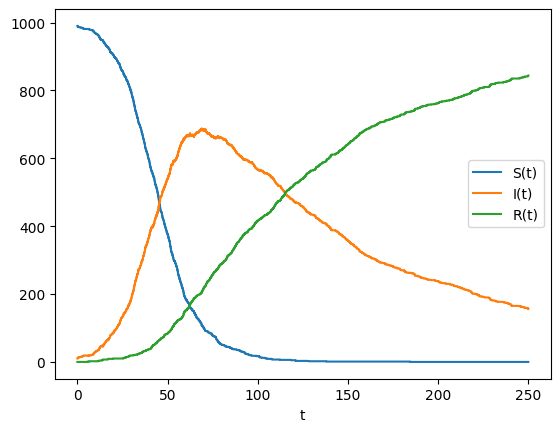

In [12]:
beta, nu = 0.1 / 1000.0, 0.01
rate = lambda t, u, p: jnp.array([p["beta"] * u[0] * u[1], p["nu"] * u[1]])


def _affect_sir(t, u, p):
    # infection: S -= 1, I += 1
    u_inf = u.at[0].add(-1)
    u_inf = u_inf.at[1].add(1)
    # recovery: I -= 1, R += 1
    u_rec = u.at[1].add(-1)
    u_rec = u_rec.at[2].add(1)
    return jnp.stack((u_inf, u_rec))


affect = jx.StatelessAffect(_affect_sir)
crj = jx.ConstantRateJump(rate, affect)

u0 = jnp.array([990, 10, 0])
p = {"beta": beta, "nu": nu}
t0, t1 = 0.0, 250.0
key = jax.random.key(0)

solver = jx.SSA()
save = jx.Save(states=True, reaction_counts=True)
sol_crj = jx.solve(crj, solver, save, u0, t0=t0, t1=t1, args=p, key=key)

mask = jnp.isfinite(sol_crj.ts)
ts = sol_crj.ts[mask]
us = sol_crj.us[mask]

plt.figure()
plt.step(ts, us[:, 0], label="S(t)")
plt.step(ts, us[:, 1], label="I(t)")
plt.step(ts, us[:, 2], label="R(t)")
plt.xlabel("t")
plt.legend()
plt.show()

## SIR via MassActionJump

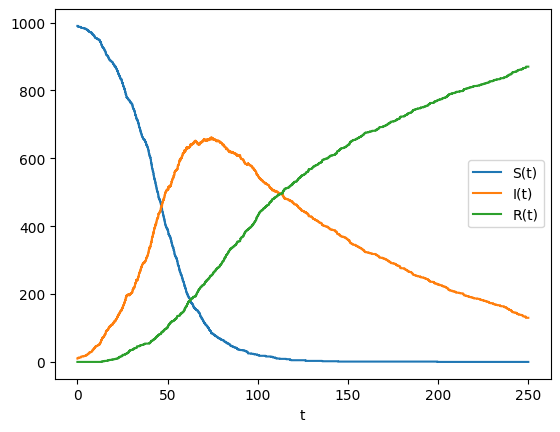

In [3]:
# Reactions in array form (reactions x species)
reactant_stoich = jnp.array(
    [
        [1, 1, 0],  # S + I
        [0, 1, 0],  # I
    ]
)
net_stoich = jnp.array(
    [
        [-1, 1, 0],  # -S + I
        [0, -1, 1],  # -I + R
    ]
)
maj = jx.MassActionJump(reactant_stoich, net_stoich, rates=jnp.array([beta, nu]))

key2 = jax.random.key(1)
sol_maj = jx.solve(maj, solver, save, u0, t0=t0, t1=t1, args=p, key=key2)

mask2 = jnp.isfinite(sol_maj.ts)
ts2 = sol_maj.ts[mask2]
us2 = sol_maj.us[mask2]

plt.figure()
plt.step(ts2, us2[:, 0], label="S(t)")
plt.step(ts2, us2[:, 1], label="I(t)")
plt.step(ts2, us2[:, 2], label="R(t)")
plt.xlabel("t")
plt.legend()
plt.show()

## τ-leaping with MassActionJump

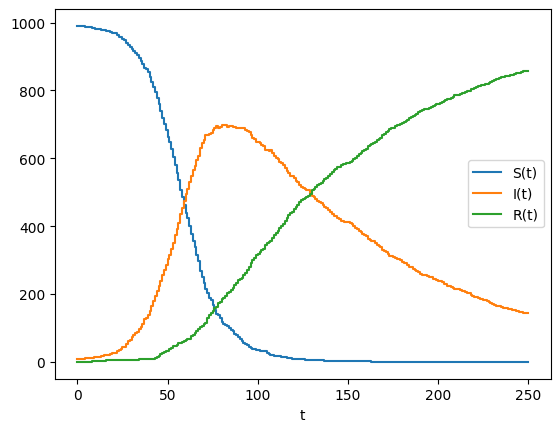

In [4]:
dt = 1.0
leaper = jx.SimpleTauLeaping(dt)
key4 = jax.random.key(3)
sol_tau_maj = jx.solve(maj, leaper, save, u0, t0=t0, t1=t1, args=None, key=key4)
mask4 = jnp.isfinite(sol_tau_maj.ts)
ts4 = sol_tau_maj.ts[mask4]
us4 = sol_tau_maj.us[mask4]
plt.figure()
plt.step(ts4, us4[:, 0], label="S(t)")
plt.step(ts4, us4[:, 1], label="I(t)")
plt.step(ts4, us4[:, 2], label="R(t)")
plt.xlabel("t")
plt.legend()
plt.show()

## Hybrid ODE + SSA
ODE evolves u[3]; jumps affect u[0:3]. Rates do not depend on u[3].

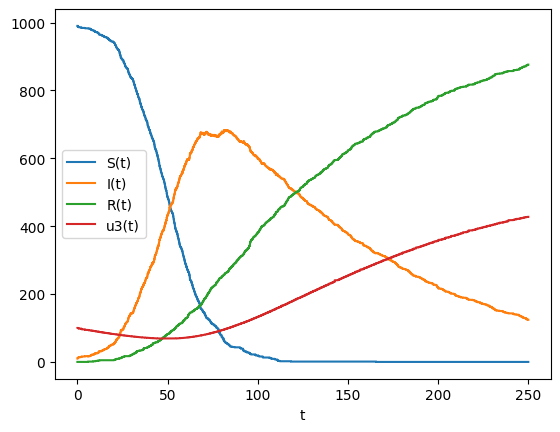

In [5]:
import diffrax as dfx


def f(t, y, args):
    # dy[3] = y[1] * y[2] / 1e5 - y[0] * y[3] / 1e5
    dy = jnp.zeros_like(y)
    dy = dy.at[3].set(y[1] * y[2] / 1e5 - y[0] * y[3] / 1e5)
    return dy


u0_h = jnp.array([990.0, 10.0, 0.0, 100.0])
beta, nu = 0.1 / 1000.0, 0.01
rate_h = lambda t, u, p: jnp.array([p["beta"] * u[0] * u[1], p["nu"] * u[1]])


def _affect_sir(t, u, p):
    u_inf = u.at[0].add(-1)
    u_inf = u_inf.at[1].add(1)
    u_rec = u.at[1].add(-1)
    u_rec = u_rec.at[2].add(1)
    return jnp.stack((u_inf, u_rec))


affect_h = jx.StatelessAffect(_affect_sir)
crj_h = jx.ConstantRateJump(rate_h, affect_h)
p_h = {"beta": beta, "nu": nu}

hyb = jx.HybridSSA(f, solver=dfx.Tsit5(), dt0=1e-1)
key6 = jax.random.key(5)
save = jx.Save(states=True, reaction_counts=True)
sol_h = jx.solve(crj_h, hyb, save, u0_h, t0=0.0, t1=250.0, args=p_h, key=key6)

maskh = jnp.isfinite(sol_h.ts)
tsh = sol_h.ts[maskh]
ush = sol_h.us[maskh]

plt.figure()
plt.step(tsh, ush[:, 0], label="S(t)")
plt.step(tsh, ush[:, 1], label="I(t)")
plt.step(tsh, ush[:, 2], label="R(t)")
plt.step(tsh, ush[:, 3], label="u3(t)")
plt.xlabel("t")
plt.legend()
plt.show()

## General Variable-Rate Jump

Add a reaction with rate 1e-2 * u[3] that increases I by 1. Rates depend on ODE-evolved u[3].

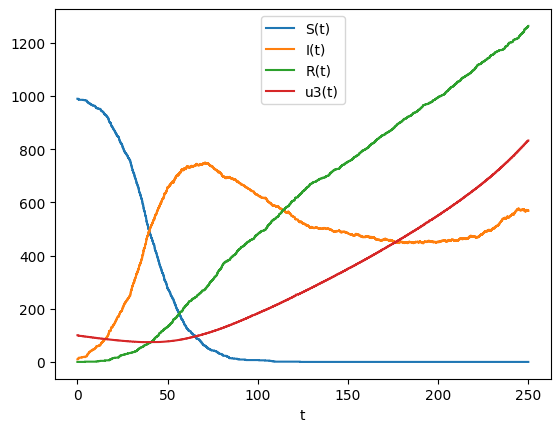

In [8]:
rate_v = lambda t, u, p: jnp.array(
    [p["beta"] * u[0] * u[1], p["nu"] * u[1], 1e-2 * u[3]]
)


def _affect_sir_var(t, u, p):
    # infection
    u_inf = u.at[0].add(-1)
    u_inf = u_inf.at[1].add(1)
    # recovery
    u_rec = u.at[1].add(-1)
    u_rec = u_rec.at[2].add(1)
    # variable-rate: I += 1
    u_var = u.at[1].add(1)
    return jnp.stack((u_inf, u_rec, u_var))


crj_v = jx.ConstantRateJump(rate_v, jx.StatelessAffect(_affect_sir_var))
haz = jx.HazardSSA(
    f, solver=dfx.Tsit5(), dt0=1e-1
)  # , stepsize_controller=dfx.PIDController(rtol=1e-5, atol=1e-7))
u0_v = jnp.array([990.0, 10.0, 0.0, 100.0])
key7 = jax.random.key(6)
sol_v = jx.solve(crj_v, haz, save, u0_v, t0=0.0, t1=250.0, args=p_h, key=key7)

maskv = jnp.isfinite(sol_v.ts)
tsv = sol_v.ts[maskv]
usv = sol_v.us[maskv]

plt.figure()
plt.step(tsv, usv[:, 0], label="S(t)")
plt.step(tsv, usv[:, 1], label="I(t)")
plt.step(tsv, usv[:, 2], label="R(t)")
plt.step(tsv, usv[:, 3], label="u3(t)")
plt.xlabel("t")
plt.legend()
plt.show()

In [9]:
print(sol_v.stats["num_steps"])
print(sol_v.counts)
print(jnp.diff(sol_v.ts[jnp.isfinite(sol_v.ts)])[:20])
print(sol_h.stats["num_steps"])
print(sol_h.counts)

3088
[ 990 1264  833]
[0.51814586 0.02698904 0.10867316 0.03910464 0.16283113 1.3336401
 0.45395732 0.658875   0.7667401  0.33237362 0.02027369 0.03518486
 0.8102646  0.04348278 0.0493474  0.02558041 0.04307079 0.07930756
 0.11707258 0.05244255]
1867
[990 876]
